# Sentiment Classifier on IMDB 50K Dataset (Macromill Task)


In this notebook, We have done the following things :
* Exploraty Data Analysis on IMDB 50k Dataset
* Finetuning of a pretrained **Distil-BERT** model for sentiment analysis of movie reviews
* Result Evaluation
* Creating a Dockerimage
* Serving the model as an API using FastAPI
* Proposed some strategies to detect degradation and automatically retrain/redeploy

## Environment Setup
* Clone the repository ````git clone https://github.com/realsazzad/macromil-task.git````
* Create a virtual environment
* Install Python 3.9
* Install Pytorch 2.8.0 with cuda 12.6
* Install Docker
* Run ````pip install -r requirements.txt````

### Import Necessary libraries

In [20]:
from run_preprocessing import load_and_prepare_data
from run_training import train_model
from run_evaluation import get_test_prediction, plot_eval_dashboard
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

### Load Dataset

* **[Important]** Put the imdb data in folder ````data/imdb_all.csv```` 

In [7]:
train_df, test_df = load_and_prepare_data()
print(train_df.head())

Loading the IMDB dataset...
                                              review  label
0  The film disappointed me for many reasons: fir...      0
1  Can this "film" be considered as a film? Imagi...      0
2  not really sure what to make of this movie. ve...      1
3  Wow, I forgot how great this movie was until I...      1
4  Produced by International Playhouse Pictures, ...      0


### EDA

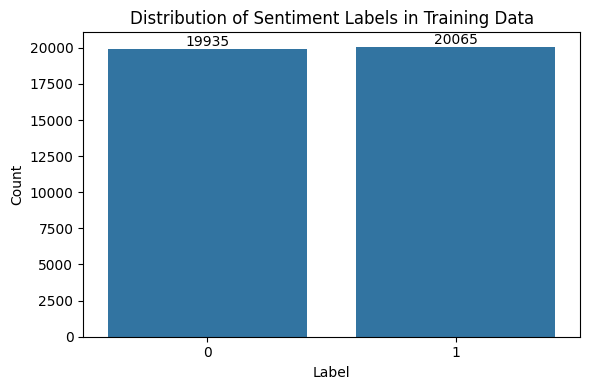

In [9]:
# Label distribution
label_counts = train_df['label'].value_counts().sort_index()
plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Distribution of Sentiment Labels in Training Data")
plt.xlabel("Label")
plt.ylabel("Count")
for idx, value in enumerate(label_counts.values):
    plt.text(idx, value + max(label_counts.values) * 0.01, str(value), ha='center')
plt.tight_layout()
plt.show()

We can see the labels are evenly distributed {0 being the Negative and 1 being the Positive class}

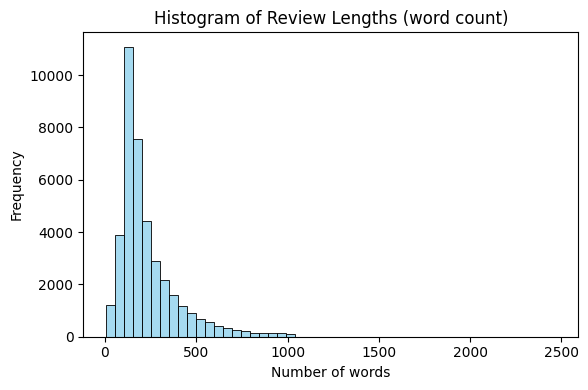

In [10]:
# Review length analysis
train_df['review_length'] = train_df['review'].apply(lambda x: len(x.split()))
plt.figure(figsize=(6, 4))
sns.histplot(train_df['review_length'], bins=50, color="skyblue", kde=False)
plt.title("Histogram of Review Lengths (word count)")
plt.xlabel("Number of words")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Most of the reivews have less than 500 words. 

### Model Training

Next we will finetune **Distil-BERT** model from Huggingface for this downstream task. It will save the best performing model in folder named distilbert-imdb-best. In our environment with GPU 3070 RTX, the training took approx 20 mintunes with evaluation accuracy around **92%**. 

In [ ]:
train_model(train_df, test_df)

### Model Evaluation
We will evalute the model on test dataset on various metrics

In [22]:
y_true, y_score = get_test_prediction("distilbert-imdb-best", "data/test_df.csv")
plot_eval_dashboard(y_true, y_score)

{'auc': 0.9757583431599941,
 'ap': 0.9747761328783776,
 'best_f1': 0.9215862551193686,
 'best_threshold': 0.36000000000000004}

![alt text](eval_dashboard.png "Title")

We can see the model produce F1 score around 92%  

### Model Serving using Fast API
Next We built a docker image and served the model using FastAPI library. Check **README.md** on how to build & run docker image. Also check **app.py** on api request structure.  

### Model Perfromance Monitoring
We can monitor the model performance on daily, weekly, monthly. A good KPI for this taks is the accuracy or F1 score or AUC score. A practical workflow would be like this:

1. Logging everything from request, response, latency, inference speed

2. Running data drift job daily : if thresholds exceeded → trigger “labeling job”

3. Time to time data labeling

4. Running model evaluation and mointor them closely


### Model Retrain/Redeploy Stategy

1. Training on original + new labeled data

2. Evaluate on fixed test set with and latest set labeled as production set

3. Deploying shadow models and rollback if performance gets worse